#SAM for colab

colab setting

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: False
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-p9onf_e2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-p9onf_e2
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=28880bb02125bc69542ec4b4adb0b26a8a1dd54181d3709cf14fb924050f4611
  Stored in directory: /tmp/pip-ephem-wheel-cache-b77wscc5/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-03-21 14:41:19--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.co

import and show marged_image function

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True) #ordina le maschere per ordine di area
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4)) #crea immagine RGBA trasparente
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]]) #colore casuale per ogni maschera più trasparenza
        img[m] = color_mask
    ax.imshow(img)

Load and image statistic

In [ ]:
image = cv2.imread('/content/201812_cropped_exg_normalized.png') # da modificare con la propria immagine
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Ottieni altezza e larghezza
height, width, _ = image.shape

print(f"Larghezza: {width} px, Altezza: {height} px")

# OSSERVAZIONE: Nel caso di immagini satellitari, ho un rettangolo di cui posso calcolare base e altezza, nel caso di immagine mediche non saprei..
# Dimensioni reali dell'immagine (in metri)
real_width_m = 2050
real_height_m = 2430

# Risoluzione (m/pixel)
res_x = real_width_m / width
res_y = real_height_m / height

print(f"Risoluzione: {res_x:.3f} m/pixel (orizzontale), {res_y:.3f} m/pixel (verticale)")

# Media delle risoluzioni per ottenere la media m/pixel
res_avg = (res_x + res_y) / 2
print(f"Risoluzione media: {res_avg:.3f} m/pixel)")

Larghezza: 3650 px, Altezza: 4100 px
Risoluzione: 0.562 m/pixel (orizzontale), 0.593 m/pixel (verticale)
Risoluzione media: 0.577 m/pixel)


In [ ]:
# Ridimensionare l'immagine
scale_percent = 20
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
image_resized = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)

SAM model load

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

**default model**

In [ ]:
masks_default = mask_generator.generate(image_resized)

KeyboardInterrupt: 

In [ ]:
print(len(masks_default))
print(masks_default[0].keys())

92
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image_resized)
show_anns(masks_default)
plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**customised model**
There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image_resized)

In [ ]:
len(masks2)

185

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image_resized)
show_anns(masks2)
plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.



---



---


**Funzione per filtrare le maschere ottenute dopo la funzione .generate()**


Prende in input la lista di maschere masks generata da SAM.
Applica un filtro basato su:


*  predicted_iou > 0.85
*  stability_score > 0.9



Restituisce solo le maschere che soddisfano entrambi i criteri.



---



---



In [ ]:
def filter_high_quality_masks(masks, iou_threshold=0.87, stability_threshold=0.95):
    """
    Filtra le maschere di SAM in base ai valori di predicted_iou e stability_score.

    Args:
        masks (list): Lista di dizionari contenenti le maschere generate da SAM.
        iou_threshold (float): Soglia minima per predicted_iou.
        stability_threshold (float): Soglia minima per stability_score.

    Returns:
        list: Lista delle maschere che superano le soglie di qualità.
    """
    high_quality_masks = [
        mask for mask in masks
        if mask["predicted_iou"] > iou_threshold and mask["stability_score"] > stability_threshold
    ]
    return high_quality_masks

In [ ]:
# Esempio di utilizzo:
# Supponiamo di avere una lista di maschere chiamata `masks`
filtered_masks = filter_high_quality_masks(masks2)

# Stampa il numero di maschere filtrate
print(f"Numero di maschere filtrate: {len(filtered_masks)}")

Numero di maschere filtrate: 106


In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image_resized)
show_anns(filtered_masks)
plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.



---



---


**Strategia per filtrare le maschere per area (in m^2 e in pixel)**

1. Calcolare la stima dell'area reale
2.   Definire un intervallo accettabile per l’area


*   Un valore minimo (min_area) per escludere maschere troppo piccole che potrebbero essere rumore.
*   Un valore massimo (max_area) per eliminare maschere troppo grandi che non rappresentano singoli fairy rings.
3.   Modificare la funzione di filtraggio per includere questo nuovo criterio.



---

---


Analisi delle aree: si stima per ogni maschera l'area reale.

In [ ]:
import numpy as np

def add_real_area_to_masks(masks, real_avg):
    """
    Aggiunge a ciascuna maschera una nuova chiave 'real_area' (in metri quadrati),
    calcolata sulla base dell'area in pixel e della risoluzione spaziale dell'immagine.
    """

    for mask in masks:
        pixel_area = mask.get('area', None)
        if pixel_area is not None:
            real_area = pixel_area * (res_avg ** 2)
            mask['real_area'] = real_area
        else:
            mask['real_area'] = None  # Nessuna area trovata

    return masks


In [ ]:
# masks_default è la lista che ti restituisce SAM (una lista di dizionari)
masks = add_real_area_to_masks(filtered_masks, res_avg)

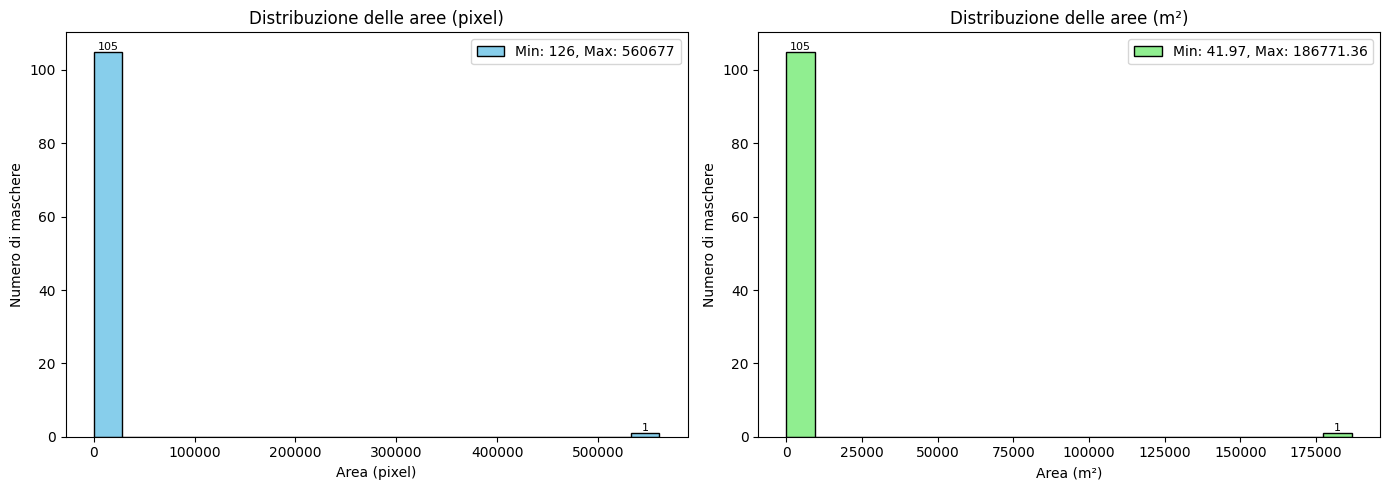

In [ ]:
import matplotlib.pyplot as plt

# Dati delle aree
areas_pixel = [mask["area"] for mask in filtered_masks]
areas_real = [mask["real_area"] for mask in filtered_masks]

# Calcolo min e max
min_pixel, max_pixel = min(areas_pixel), max(areas_pixel)
min_real, max_real = min(areas_real), max(areas_real)

# Creazione dei subplot
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- Istogramma delle aree in pixel ---
counts_pixel, bins_pixel, patches_pixel = axs[0].hist(areas_pixel, bins=20, color='skyblue', edgecolor='black')
axs[0].set_xlabel("Area (pixel)")
axs[0].set_ylabel("Numero di maschere")
axs[0].set_title("Distribuzione delle aree (pixel)")
axs[0].legend([f"Min: {min_pixel}, Max: {max_pixel}"], loc='upper right')

# Aggiunta delle etichette su ogni barra
for count, patch in zip(counts_pixel, patches_pixel):
    if count > 0:
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        axs[0].text(x, y, int(count), ha='center', va='bottom', fontsize=8)

# --- Istogramma delle aree in metri quadrati ---
counts_real, bins_real, patches_real = axs[1].hist(areas_real, bins=20, color='lightgreen', edgecolor='black')
axs[1].set_xlabel("Area (m²)")
axs[1].set_ylabel("Numero di maschere")
axs[1].set_title("Distribuzione delle aree (m²)")
axs[1].legend([f"Min: {min_real:.2f}, Max: {max_real:.2f}"], loc='upper right')

# Aggiunta delle etichette su ogni barra
for count, patch in zip(counts_real, patches_real):
    if count > 0:
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        axs[1].text(x, y, int(count), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

**Osservazione:** sul grafico precedente, le maschere utilizzate per il calcolo della distribuzione sono 106 ottenute dopo il filtro di qualità. sarebbe bene fare questa analisi prima del filtro di qualità?

In [ ]:
def filter_masks_by_pixel_area(masks, min_area=500, max_area=50000):
    """
    Filtra le maschere in base all'area inpixel.
    """
    filtered_masks = [
        mask for mask in masks
        if min_area <= mask["area"] <= max_area
    ]
    return filtered_masks

In [ ]:
# Esempio di utilizzo:
filtered_pixel_area_masks = filter_masks_by_pixel_area(filtered_masks, min_area=50, max_area=1000)

# Stampa il numero di maschere rimaste dopo il filtro per area
print(f"Maschere dopo il filtro per area in pixel: {len(filtered_pixel_area_masks)}")

Maschere dopo il filtro per area in pixel: 96


In [ ]:
def filter_masks_by_real_area(masks, min_area=40, max_area=1000):
    """
    Filtra le maschere in base all'area stimata in m^2
    """
    filtered_masks = [
        mask for mask in masks
        if min_area <= mask["real_area"] <= max_area
    ]
    return filtered_masks

In [ ]:
# Esempio di utilizzo:
filtered_real_area_masks = filter_masks_by_real_area(filtered_masks, min_area=40, max_area=1000)

# Stampa il numero di maschere rimaste dopo il filtro per area
print(f"Maschere dopo il filtro per area in m^2: {len(filtered_real_area_masks)}")

Maschere dopo il filtro per area in m: 99


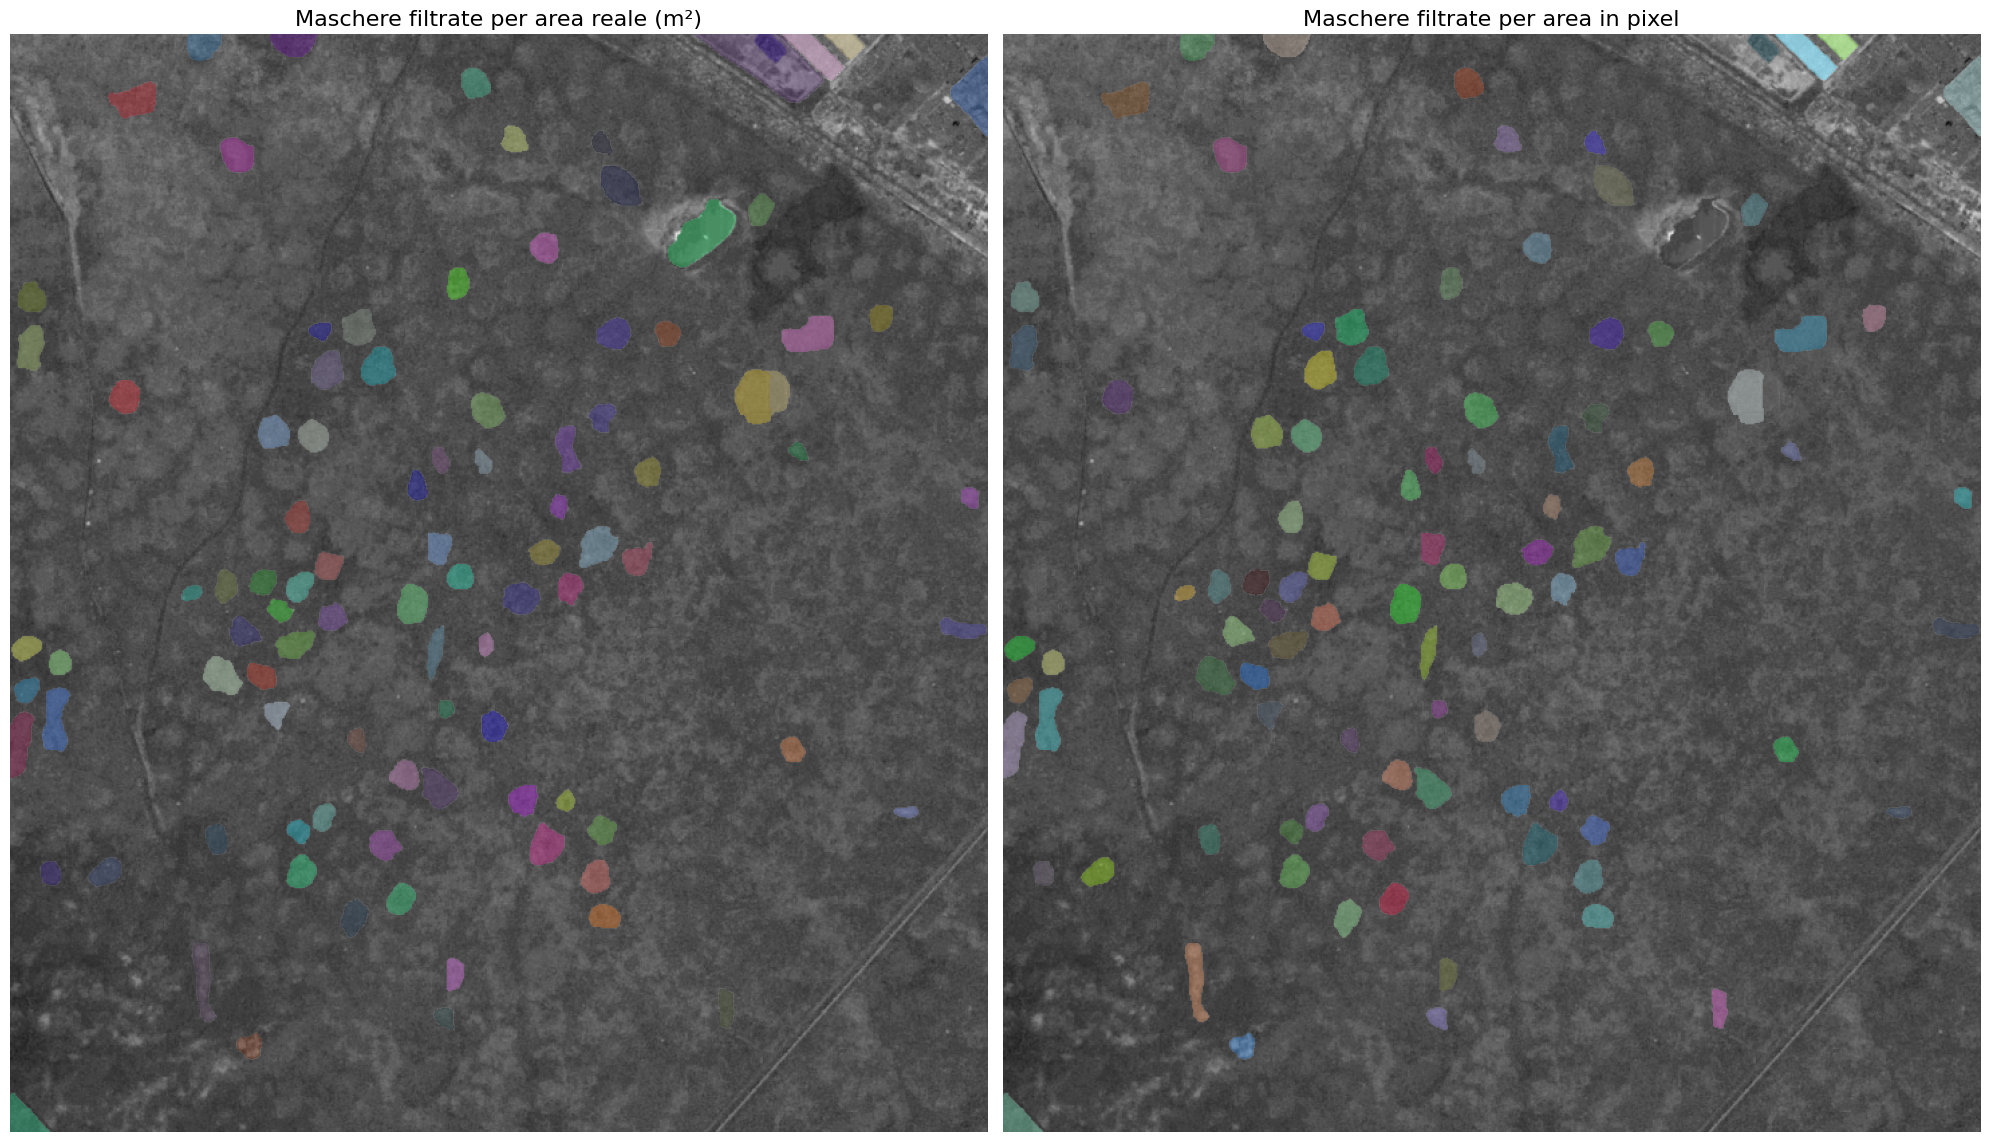

In [ ]:
import matplotlib.pyplot as plt

# Crea due subplot affiancati
fig, axs = plt.subplots(1, 2, figsize=(20, 20))

# --- SINISTRA: maschere filtrate per area reale ---
plt.sca(axs[0])  # imposta axs[0] come "current axis"
axs[0].imshow(image_resized)
show_anns(filtered_real_area_masks)
axs[0].axis('off')
axs[0].set_title("Maschere filtrate per area reale (m²)", fontsize=16)

# --- DESTRA: maschere filtrate per area in pixel ---
plt.sca(axs[1])  # imposta axs[1] come "current axis"
axs[1].imshow(image_resized)
show_anns(filtered_pixel_area_masks)
axs[1].axis('off')
axs[1].set_title("Maschere filtrate per area in pixel", fontsize=16)

plt.tight_layout()
plt.show()


**Risultato:** da notare il triangolo in basso a sinistra. con il filtro per area reale e in pixel viene conservato come maschera ma la prossima funzione, quella di roundness, farà in modo che tale triangolo venga scartato.


---
**Problema: ** nessuna funzione riesce però a scartare il rettangolo in alto a destra.


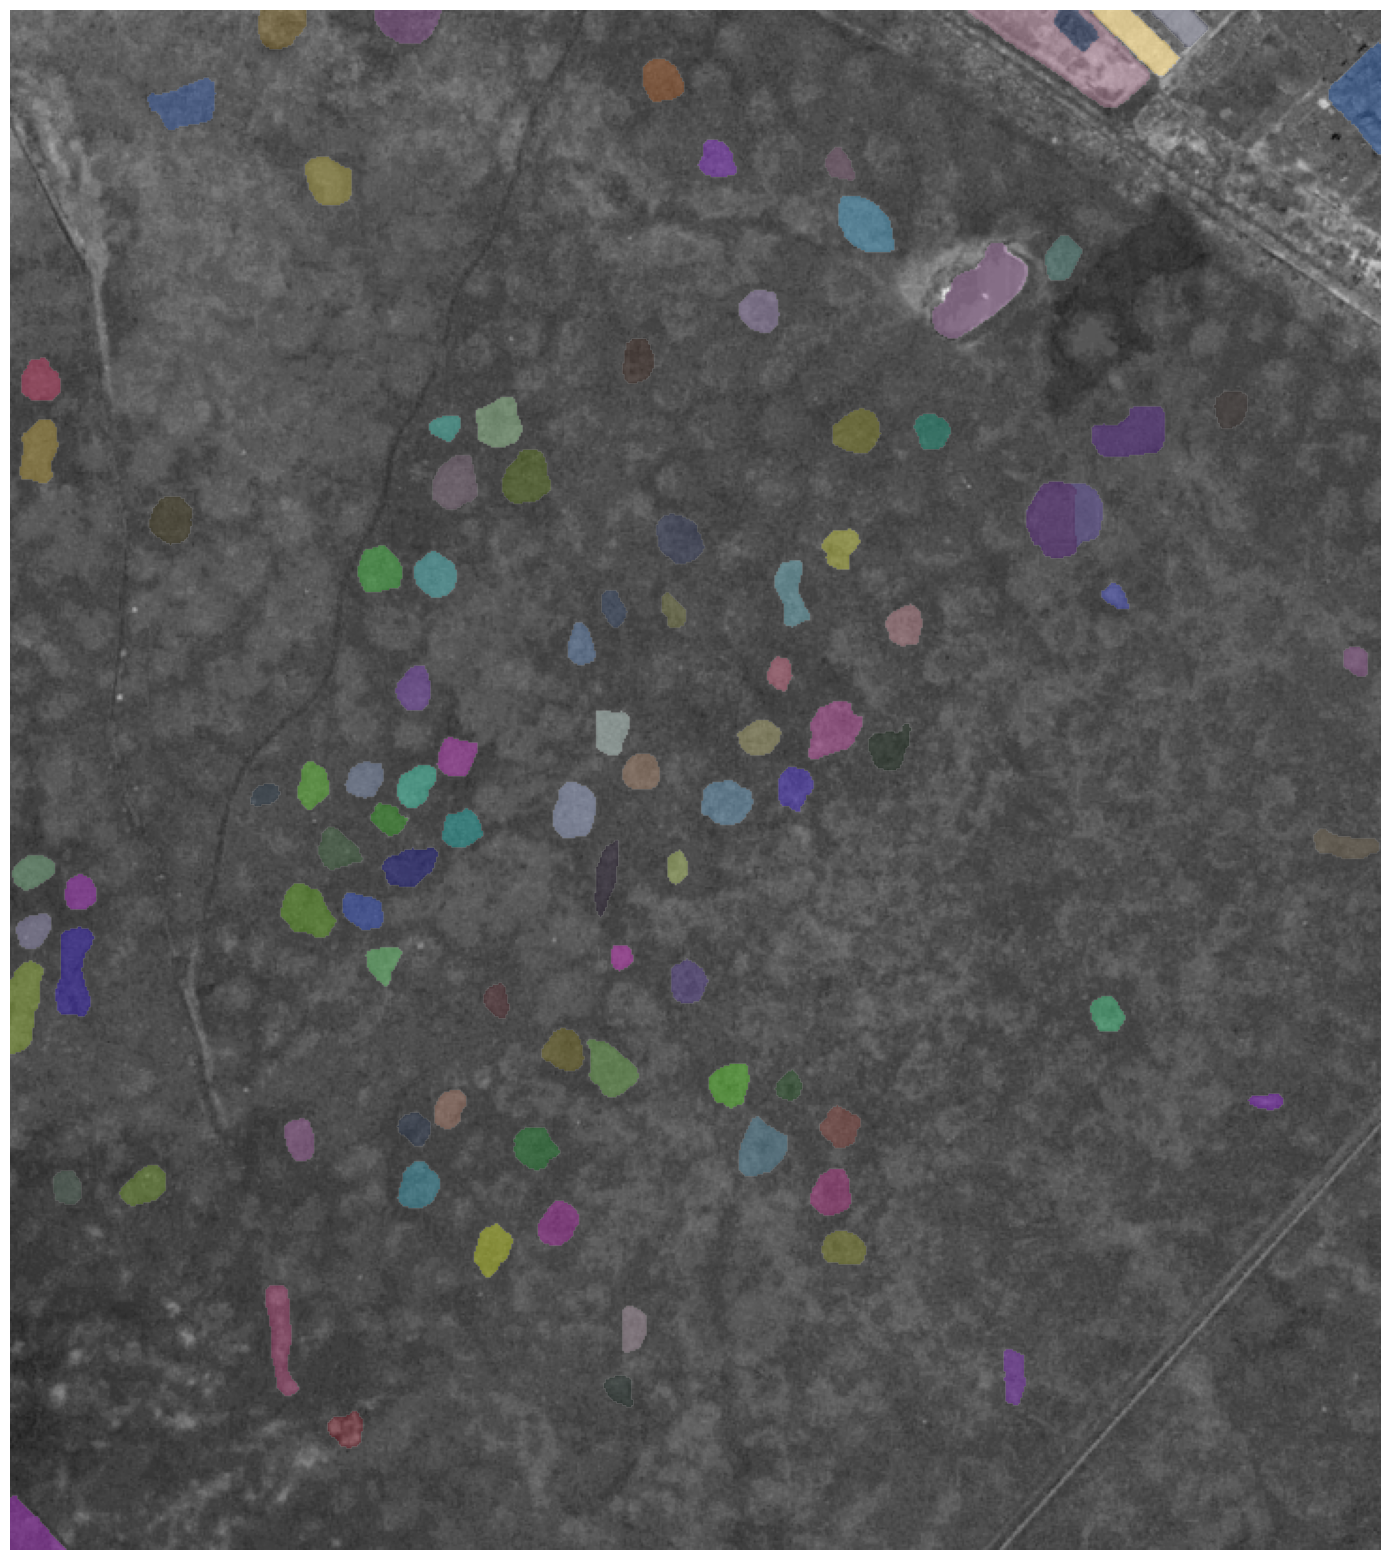

In [ ]:
# Per visualizzare una sola delle due immagini
plt.figure(figsize=(20,20))
plt.imshow(image_resized)
show_anns(filtered_pixel_area_masks) # da modificare con filtered_real_area_masks
plt.axis('off')
plt.show()



---



---


**Roundness function**
 la funzione add_roundness_to_masks(masks_default) serve per calcolare e memorizzare la roundness per ogni maschera. La funzione prende in input la lista delle maschere delle qualisi vuole calcolare il valore di roundness, dopo l'esecuzione della funzione ogni elemento della lista avrà la chiave "roundness" con il valore calcolato. Dunque la funzione aggiorna il dizionario delle maschere generato da SAM aggiungendo il nuovo valore.

 Il valore di roundness verrà utilizzano in seguito come filtro.


---



---



In [ ]:
import numpy as np
import cv2

def compute_roundness(mask):
    """
    Compute the roundness of the white region in a binary mask.
    """
    # Convert boolean mask to uint8 (0 and 255)
    mask = mask.astype(np.uint8) * 255
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None  # No object found

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)

    if perimeter == 0:
        return None  # Avoid division by zero

    roundness = (4 * np.pi * area) / (perimeter ** 2)
    return roundness

def add_roundness_to_masks(masks_default):
    """
    Adds the computed roundness to each mask dictionary entry in masks_default.
    """
    for mask_entry in masks_default:
        mask = mask_entry['segmentation']  # Assuming this is a numpy array
        roundness = compute_roundness(mask)
        mask_entry['roundness'] = roundness  # Store roundness in the dictionary

    return masks_default

In [ ]:
roundeness_masks = add_roundness_to_masks(filtered_real_area_masks)

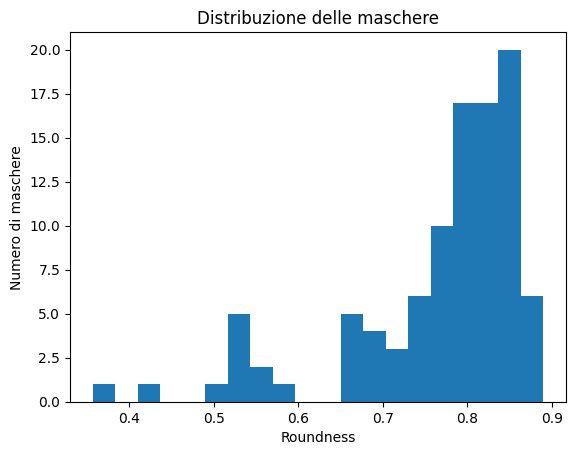

In [ ]:
areas = [mask["roundness"] for mask in roundeness_masks]
import matplotlib.pyplot as plt

plt.hist(areas, bins=20)
plt.xlabel("Roundness")
plt.ylabel("Numero di maschere")
plt.title("Distribuzione delle maschere")
plt.show()

In [ ]:
def filter_masks_by_roundness(roundeness_masks, min_roundness, max_roundness):
  """
  Filters masks based on a given roundness range.
  Returns a list of masks that have roundness within the specified range.
  """
  return [
      mask_entry for mask_entry in roundeness_masks
      if mask_entry.get('roundness') is not None and min_roundness <= mask_entry['roundness'] <= max_roundness
  ]

In [ ]:
min_roundness=0.7
max_roundness=0.9

filtered_roundeness_masks = filter_masks_by_roundness(roundeness_masks, min_roundness, max_roundness)

# Stampa il numero di maschere rimaste dopo il filtro per reoundness
print(f"Maschere dopo il filtro per roundness: {len(filtered_roundeness_masks)}")

Maschere dopo il filtro per roundness: 80


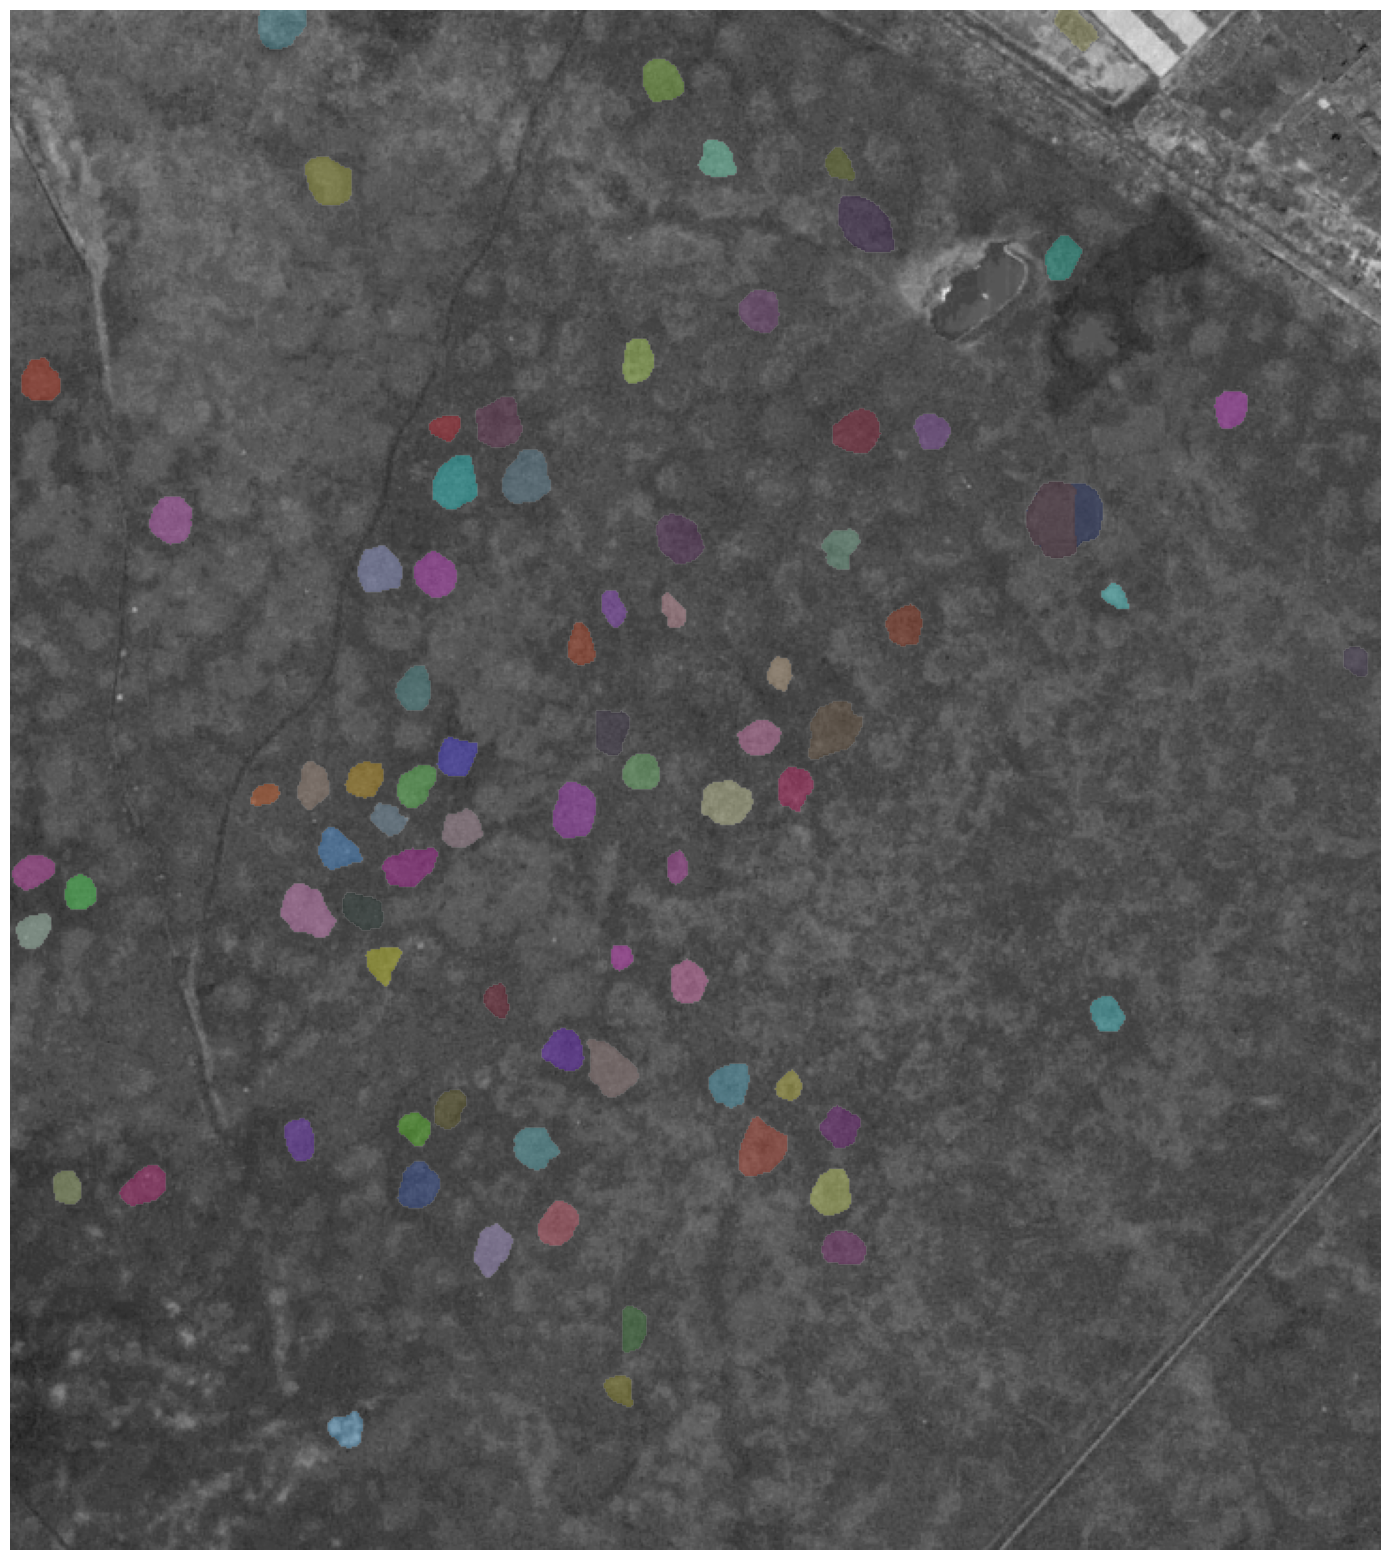

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image_resized)
show_anns(filtered_roundeness_masks)
plt.axis('off')
plt.show()